In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install keras==2.2.0

In [0]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install sklearn

In [0]:
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

import tensorflow as tf

import keras
from keras.layers import Input, Embedding, LSTM, Dense
from keras.layers.core import Reshape
from keras.models import Model

In [0]:
fbank_features = 128
mfcc_features = 13
mfcc_d_features = 13
mfcc_dd_features = 13
features_count = fbank_features + mfcc_features + \
                 mfcc_d_features + mfcc_dd_features
segments_count = 474
col_names = ["{}".format(i) for i in range(features_count)]
col_names.append("IS_LAUGHTER")

In [5]:
data_file = "gdrive/My Drive/Colab Notebooks/2_solution_colab" + \
            "/homework/vocalizationcorpus/data_csv/super_mega_file_474_expanded.csv"
data = pd.read_csv(data_file, sep=",", names=col_names)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,IS_LAUGHTER
0,-774.765868,51.965869,11.403024,38.322657,-15.187577,25.751888,7.056730,-10.047402,13.589122,-0.642071,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,0
1,-771.080759,52.170832,11.469751,39.211949,-17.354396,24.703801,9.862724,-7.481059,11.041431,-2.921237,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,0
2,-772.859716,48.599767,7.597807,37.360595,-17.867693,24.161158,7.589684,-11.482042,8.909090,-5.747069,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,0
3,-777.078815,46.571198,6.869962,37.503903,-15.772092,22.171728,3.001475,-14.345394,10.289235,-3.724221,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,0
4,-779.123295,45.040144,5.445280,37.390207,-16.665513,21.014096,6.779634,-11.556962,10.777100,-0.324580,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,0


In [0]:
def get_data(data, segments_count: int) -> (List[np.array], List[np.array], 
                                            List[np.array], List[np.array]):
    # to numpy
    data = np.array(data)
    labels = data[:,-1]
    data = data[:, :-1]
    
    # cut last incomplete file
    if data.shape[0] % 11 != 0:
        new_num_rows = (data.shape[0] // segments_count) * segments_count
        data = data[:new_num_rows]
        labels = labels[:new_num_rows]

    # to train, test
    part_size = 0.2
    parts_count = int(1./part_size)
    test_parts_count = 1
    train_size = int((data.shape[0] // segments_count) * part_size) * segments_count
    
    train_x = [data[train_size * i : train_size * (i + 1)]
               for i in range(parts_count - test_parts_count)]
    train_labels = [labels[train_size * i : train_size * (i + 1)]
                   for i in range(parts_count - test_parts_count)]
    
    test_x = [data[train_size * i : train_size * (i + 1)]
               for i in range(parts_count - test_parts_count, parts_count)]
    test_labels = [labels[train_size * i : train_size * (i + 1)]
                   for i in range(parts_count - test_parts_count, parts_count)]
    
    return train_x, train_labels, test_x, test_labels

In [7]:
train_x, train_y, test_x, test_y = get_data(data, segments_count)

print("train shape X = {}, train shape Y = {}".format(train_x[0].shape, train_y[0].shape))
print("test shape X = {}, test shape Y = {}".format(test_x[0].shape, test_y[0].shape))
print("number of train parts = {}".format(len(train_x)))
print("number of test parts = {}".format(len(test_x)))

#del data

train_samples_count = train_x[0].shape[0]
test_samples_count = test_x[0].shape[0]

train shape X = (259278, 167), train shape Y = (259278,)
test shape X = (259278, 167), test shape Y = (259278,)
number of train parts = 4
number of test parts = 1


In [8]:
# def split_data_by_features(data: List[np.array],
#                            mf, mf_d, mf_dd, fbank) -> (List[np.array], List[np.array], 
#                                                        List[np.array], List[np.array]):
#   mfcc = [part[:, : mf] for part in data]
#   mfcc_d = [part[:, mf : mf + mf_d] for part in data]
#   mfcc_dd = [part[:, mf + mf_d : mf + mf_d + mf_dd] for part in data]
#   fbank = [part[:, mf + mf_d + mf_dd :] for part in data]

#   return mfcc, mfcc_d, mfcc_dd, fbank

def split_data_by_features(data: List[np.array],
                           mf, mf_d, mf_dd, fbank) -> (List[np.array], List[np.array]):
  
      mfcc = [part[:, : mf + mf_d + mf_dd] for part in data]
      fbank = [part[:, mf + mf_d + mf_dd :] for part in data]

      return mfcc, fbank


train_mfcc, train_fbank = split_data_by_features(train_x, mfcc_features, 
                                                 mfcc_d_features, mfcc_dd_features, 
                                                 fbank_features)

print("train_mfcc shape = {}".format(train_mfcc[0].shape))
print("train_fbank shape = {}".format(train_fbank[0].shape))

train mfcc shape = (259278, 39)
train fbank shape = (259278, 128)


In [9]:
def reshape_data_for_model(mf: List[np.array], fbank: List[np.array],
                           segm_count: int, mf_c: int, fb_c: int):
  
      mf_seq = [part.reshape(part.shape[0] // segm_count, segm_count, mf_c) for part in mf]
      fbank_seq = [part.reshape(part.shape[0] // segm_count, segm_count, fb_c) for part in fbank]

      return mf_seq, fbank_seq

def reshape_labels_for_model(labels: List[np.array], segm_count: int) -> List[np.array]:
      return [part.reshape(part.shape[0] // segm_count,  segm_count, 1) for part in labels]
  
train_mf_seq, train_fbank_seq = reshape_data_for_model(train_mfcc, 
                                                       train_fbank,
                                                       segments_count, 
                                                       mfcc_features + mfcc_d_features + mfcc_dd_features, 
                                                       fbank_features)

train_y_seq = reshape_labels_for_model(train_y, segments_count)
  
print("train mfcc_seq shape = {}".format(train_mf_seq[0].shape))
print("train fbank_seq shape = {}".format(train_fbank_seq[0].shape))
print()
print("train Y seq shape = {}".format(train_y_seq[0].shape))


train mfcc seq shape = (547, 474, 39)
train fbank seq shape = (547, 474, 128)

train Y seq shape = (547, 474, 1)


In [10]:
# TEST DATA
test_mfcc, test_fbank = split_data_by_features(test_x, mfcc_features, 
                                               mfcc_d_features, mfcc_dd_features, 
                                               fbank_features)

print("test mfcc shape = {}".format(test_mfcc[0].shape))
print("test fbank shape = {}".format(test_fbank[0].shape))

test_mf_seq, test_fbank_seq = reshape_data_for_model(test_mfcc, 
                                                     test_fbank,
                                                     segments_count, 
                                                     mfcc_features + mfcc_d_features + mfcc_dd_features, 
                                                     fbank_features)

test_y_seq = reshape_labels_for_model(test_y, segments_count)

print("test_mfcc_seq shape = {}".format(test_mf_seq[0].shape))
print("test_fbank_seq shape = {}".format(test_fbank_seq[0].shape))
print()
print("test_Y_seq shape = {}".format(test_y_seq[0].shape))


test mfcc shape = (259278, 39)
test fbank shape = (259278, 128)
test_mfcc_seq shape = (547, 474, 39)
test_fbank_seq shape = (547, 474, 128)

test_Y_seq shape = (547, 474, 1)


In [38]:
mfcc_input = Input(shape=(segments_count, 
                          mfcc_features + mfcc_d_features + mfcc_dd_features), 
                   dtype='float32', name='mfcc_and_its_der_input')
lstm_out_mfcc = LSTM(mfcc_features + mfcc_d_features + mfcc_dd_features + 5, 
                     return_sequences=True,
                     dropout=0.2, 
                     recurrent_dropout=0.3)(mfcc_input)
mfcc_output = Dense(1, 
                    activation='sigmoid', 
                    name='mfcc_output')(lstm_out_mfcc)


fbank_input = Input(shape=(segments_count, fbank_features), 
                      dtype='float32', name='fbank_input')
lstm_out_fbank = LSTM(fbank_features + 5, 
                      return_sequences=True,
                      dropout=0.2, 
                      recurrent_dropout=0.3)(fbank_input)


x = keras.layers.concatenate([lstm_out_fbank, lstm_out_mfcc])
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

model = Model(inputs=[fbank_input, mfcc_input], 
              outputs=[main_output, mfcc_output])

model.compile(optimizer='adam', 
              metrics=['accuracy'], 
              loss='binary_crossentropy', 
              loss_weights=[1., 0.2])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fbank_input (InputLayer)        (None, 474, 128)     0                                            
__________________________________________________________________________________________________
mfcc_and_its_der_input (InputLa (None, 474, 39)      0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 474, 133)     139384      fbank_input[0][0]                
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 474, 44)      14784       mfcc_and_its_der_input[0][0]     
__________________________________________________________________________________________________
concatenat

In [27]:
%%time

model.fit([train_fbank_seq[0], train_mf_seq[0]], 
        [train_y_seq[0], train_y_seq[0]], 
        epochs=1, 
        steps_per_epoch=10)
model.save_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
10/10 [==============================] - 131s 13s/step - loss: 0.4018 - main_output_loss: 0.2279 - mfcc_output_loss: 0.8692 - main_output_acc: 0.9556 - mfcc_output_acc: 0.1666
CPU times: user 3min 35s, sys: 26.3 s, total: 4min 1s
Wall time: 2min 14s


In [28]:
%%time

model.fit([train_fbank_seq[0], train_mf_seq[0]], 
        [train_y_seq[0], train_y_seq[0]], 
        epochs=4, 
        steps_per_epoch=10)
model.save_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model.h5")

Epoch 1/4
10/10 [==============================] - 120s 12s/step - loss: 0.3226 - main_output_loss: 0.1776 - mfcc_output_loss: 0.7246 - main_output_acc: 0.9571 - mfcc_output_acc: 0.4446
Epoch 2/4
10/10 [==============================] - 119s 12s/step - loss: 0.2890 - main_output_loss: 0.1737 - mfcc_output_loss: 0.5765 - main_output_acc: 0.9571 - mfcc_output_acc: 0.7885
Epoch 3/4
10/10 [==============================] - 117s 12s/step - loss: 0.2542 - main_output_loss: 0.1704 - mfcc_output_loss: 0.4190 - main_output_acc: 0.9571 - mfcc_output_acc: 0.9248
Epoch 4/4
10/10 [==============================] - 118s 12s/step - loss: 0.2314 - main_output_loss: 0.1670 - mfcc_output_loss: 0.3223 - main_output_acc: 0.9571 - mfcc_output_acc: 0.9486
CPU times: user 13min 32s, sys: 1min 19s, total: 14min 52s
Wall time: 7min 54s


In [30]:
%%time

result_train_0 = np.array(model.predict([train_fbank_seq[0], train_mf_seq[0]], 
                                       steps=1, 
                                       verbose=1))[0].reshape(train_y_seq[0].shape[0],
                                                              train_y_seq[0].shape[1])

print("AUC = {}".format(roc_auc_score(train_y_seq[0].reshape(train_y_seq[0].shape[0], train_y_seq[0].shape[1]), 
                                      result_train_0)))

1/1 [==============================] - 3s 3s/step
AUC = 0.7605569377090595
CPU times: user 6.46 s, sys: 363 ms, total: 6.82 s
Wall time: 3.76 s


In [31]:
%%time

model.fit([train_fbank_seq[1], train_mf_seq[1]], 
        [train_y_seq[1], train_y_seq[1]], 
        epochs=5, 
        steps_per_epoch=10)
model.save_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model.h5")

Epoch 1/5
10/10 [==============================] - 118s 12s/step - loss: 0.1487 - main_output_loss: 0.1000 - mfcc_output_loss: 0.2436 - main_output_acc: 0.9785 - mfcc_output_acc: 0.9741
Epoch 2/5
10/10 [==============================] - 118s 12s/step - loss: 0.1397 - main_output_loss: 0.0969 - mfcc_output_loss: 0.2141 - main_output_acc: 0.9785 - mfcc_output_acc: 0.9770
Epoch 3/5
10/10 [==============================] - 117s 12s/step - loss: 0.1313 - main_output_loss: 0.0947 - mfcc_output_loss: 0.1828 - main_output_acc: 0.9785 - mfcc_output_acc: 0.9779
Epoch 4/5
10/10 [==============================] - 119s 12s/step - loss: 0.1227 - main_output_loss: 0.0935 - mfcc_output_loss: 0.1458 - main_output_acc: 0.9785 - mfcc_output_acc: 0.9782
Epoch 5/5
10/10 [==============================] - 118s 12s/step - loss: 0.1184 - main_output_loss: 0.0935 - mfcc_output_loss: 0.1248 - main_output_acc: 0.9785 - mfcc_output_acc: 0.9783
CPU times: user 16min 59s, sys: 1min 34s, total: 18min 34s
Wall time: 

In [35]:
%%time

model.fit([train_fbank_seq[2], train_mf_seq[2]], 
        [train_y_seq[2], train_y_seq[2]], 
        epochs=5, 
        steps_per_epoch=10)
model.save_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model.h5")

Epoch 1/5
10/10 [==============================] - 123s 12s/step - loss: 0.1629 - main_output_loss: 0.1318 - mfcc_output_loss: 0.1550 - main_output_acc: 0.9669 - mfcc_output_acc: 0.9662
Epoch 2/5
10/10 [==============================] - 118s 12s/step - loss: 0.1611 - main_output_loss: 0.1309 - mfcc_output_loss: 0.1513 - main_output_acc: 0.9669 - mfcc_output_acc: 0.9666
Epoch 3/5
10/10 [==============================] - 118s 12s/step - loss: 0.1589 - main_output_loss: 0.1290 - mfcc_output_loss: 0.1495 - main_output_acc: 0.9669 - mfcc_output_acc: 0.9668
Epoch 4/5
10/10 [==============================] - 118s 12s/step - loss: 0.1583 - main_output_loss: 0.1284 - mfcc_output_loss: 0.1497 - main_output_acc: 0.9669 - mfcc_output_acc: 0.9666
Epoch 5/5
10/10 [==============================] - 119s 12s/step - loss: 0.1582 - main_output_loss: 0.1283 - mfcc_output_loss: 0.1494 - main_output_acc: 0.9669 - mfcc_output_acc: 0.9667
CPU times: user 17min 7s, sys: 1min 37s, total: 18min 44s
Wall time: 9

In [36]:
%%time

result_test_1 = np.array(model.predict([test_fbank_seq[0], test_mf_seq[0]], 
                                       steps=1, 
                                       verbose=1))[0].reshape(test_y_seq[0].shape[0],
                                                              test_y_seq[0].shape[1])

print("\nAUC on test = {}\n".format(roc_auc_score(test_y_seq[0].reshape(test_y_seq[0].shape[0], test_y_seq[0].shape[1]), 
                                                  result_train_1)))

1/1 [==============================] - 4s 4s/step

AUC on test = 0.5034193821896985

CPU times: user 6.72 s, sys: 430 ms, total: 7.15 s
Wall time: 4.08 s


In [37]:
%%time

result_train_2 = np.array(model.predict([train_fbank_seq[2], train_mf_seq[2]], 
                                       steps=1, 
                                       verbose=1))[0].reshape(train_y_seq[2].shape[0],
                                                              train_y_seq[2].shape[1])

print("AUC = {}".format(roc_auc_score(train_y_seq[2].reshape(train_y_seq[2].shape[0], train_y_seq[2].shape[1]), 
                                      result_train_2)))

1/1 [==============================] - 4s 4s/step
AUC = 0.8135390548348582
CPU times: user 6.87 s, sys: 359 ms, total: 7.23 s
Wall time: 3.95 s


In [38]:
%%time

model.fit([train_fbank_seq[3], train_mf_seq[3]], 
        [train_y_seq[3], train_y_seq[3]], 
        epochs=5, 
        steps_per_epoch=10)
model.save_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model.h5")

Epoch 1/5
10/10 [==============================] - 117s 12s/step - loss: 0.1304 - main_output_loss: 0.1058 - mfcc_output_loss: 0.1229 - main_output_acc: 0.9751 - mfcc_output_acc: 0.9748
Epoch 2/5
10/10 [==============================] - 117s 12s/step - loss: 0.1284 - main_output_loss: 0.1040 - mfcc_output_loss: 0.1217 - main_output_acc: 0.9751 - mfcc_output_acc: 0.9749
Epoch 3/5
10/10 [==============================] - 117s 12s/step - loss: 0.1282 - main_output_loss: 0.1039 - mfcc_output_loss: 0.1214 - main_output_acc: 0.9751 - mfcc_output_acc: 0.9748
Epoch 4/5
10/10 [==============================] - 116s 12s/step - loss: 0.1267 - main_output_loss: 0.1026 - mfcc_output_loss: 0.1204 - main_output_acc: 0.9751 - mfcc_output_acc: 0.9750
Epoch 5/5
10/10 [==============================] - 118s 12s/step - loss: 0.1255 - main_output_loss: 0.1017 - mfcc_output_loss: 0.1193 - main_output_acc: 0.9751 - mfcc_output_acc: 0.9749
CPU times: user 16min 51s, sys: 1min 32s, total: 18min 24s
Wall time: 

In [39]:
%%time

result_test_1 = np.array(model.predict([test_fbank_seq[0], test_mf_seq[0]], 
                                       steps=1, 
                                       verbose=1))[0].reshape(test_y_seq[0].shape[0],
                                                              test_y_seq[0].shape[1])

print("\nAUC on test = {}\n".format(roc_auc_score(test_y_seq[0].reshape(test_y_seq[0].shape[0], test_y_seq[0].shape[1]), 
                                                  result_train_1)))

1/1 [==============================] - 4s 4s/step

AUC on test = 0.5034193821896985

CPU times: user 7.18 s, sys: 400 ms, total: 7.58 s
Wall time: 4.12 s


In [40]:
%%time

model.fit([train_fbank_seq[3], train_mf_seq[3]], 
        [train_y_seq[3], train_y_seq[3]], 
        epochs=15, 
        steps_per_epoch=10)
model.save_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model.h5")

Epoch 1/15
10/10 [==============================] - 116s 12s/step - loss: 0.1250 - main_output_loss: 0.1012 - mfcc_output_loss: 0.1187 - main_output_acc: 0.9751 - mfcc_output_acc: 0.9748
Epoch 2/15
10/10 [==============================] - 115s 11s/step - loss: 0.1239 - main_output_loss: 0.1004 - mfcc_output_loss: 0.1176 - main_output_acc: 0.9751 - mfcc_output_acc: 0.9748
Epoch 3/15
10/10 [==============================] - 111s 11s/step - loss: 0.1234 - main_output_loss: 0.1001 - mfcc_output_loss: 0.1164 - main_output_acc: 0.9751 - mfcc_output_acc: 0.9749
Epoch 4/15
10/10 [==============================] - 109s 11s/step - loss: 0.1220 - main_output_loss: 0.0989 - mfcc_output_loss: 0.1155 - main_output_acc: 0.9751 - mfcc_output_acc: 0.9750
Epoch 5/15
10/10 [==============================] - 113s 11s/step - loss: 0.1216 - main_output_loss: 0.0983 - mfcc_output_loss: 0.1161 - main_output_acc: 0.9751 - mfcc_output_acc: 0.9750
Epoch 6/15
10/10 [==============================] - 112s 11s/step

In [41]:
%%time

model.fit([train_fbank_seq[0], train_mf_seq[0]], 
        [train_y_seq[0], train_y_seq[0]], 
        epochs=15, 
        steps_per_epoch=10)
model.save_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model.h5")

Epoch 1/15
10/10 [==============================] - 111s 11s/step - loss: 0.1798 - main_output_loss: 0.1461 - mfcc_output_loss: 0.1685 - main_output_acc: 0.9571 - mfcc_output_acc: 0.9571
Epoch 2/15
10/10 [==============================] - 109s 11s/step - loss: 0.1755 - main_output_loss: 0.1422 - mfcc_output_loss: 0.1661 - main_output_acc: 0.9575 - mfcc_output_acc: 0.9570
Epoch 3/15
10/10 [==============================] - 109s 11s/step - loss: 0.1727 - main_output_loss: 0.1400 - mfcc_output_loss: 0.1634 - main_output_acc: 0.9576 - mfcc_output_acc: 0.9571
Epoch 4/15
10/10 [==============================] - 109s 11s/step - loss: 0.1714 - main_output_loss: 0.1391 - mfcc_output_loss: 0.1619 - main_output_acc: 0.9577 - mfcc_output_acc: 0.9571
Epoch 5/15
10/10 [==============================] - 109s 11s/step - loss: 0.1705 - main_output_loss: 0.1385 - mfcc_output_loss: 0.1603 - main_output_acc: 0.9578 - mfcc_output_acc: 0.9571
Epoch 6/15
10/10 [==============================] - 113s 11s/step

In [42]:
%%time

model.fit([train_fbank_seq[1], train_mf_seq[1]], 
        [train_y_seq[1], train_y_seq[1]], 
        epochs=15, 
        steps_per_epoch=10)
model.save_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model.h5")

Epoch 1/15
10/10 [==============================] - 111s 11s/step - loss: 0.1016 - main_output_loss: 0.0826 - mfcc_output_loss: 0.0950 - main_output_acc: 0.9786 - mfcc_output_acc: 0.9785
Epoch 2/15
10/10 [==============================] - 115s 12s/step - loss: 0.0992 - main_output_loss: 0.0806 - mfcc_output_loss: 0.0929 - main_output_acc: 0.9788 - mfcc_output_acc: 0.9785
Epoch 3/15
10/10 [==============================] - 114s 11s/step - loss: 0.0966 - main_output_loss: 0.0783 - mfcc_output_loss: 0.0918 - main_output_acc: 0.9790 - mfcc_output_acc: 0.9785
Epoch 4/15
10/10 [==============================] - 115s 11s/step - loss: 0.0967 - main_output_loss: 0.0784 - mfcc_output_loss: 0.0915 - main_output_acc: 0.9788 - mfcc_output_acc: 0.9785
Epoch 5/15
10/10 [==============================] - 114s 11s/step - loss: 0.0960 - main_output_loss: 0.0778 - mfcc_output_loss: 0.0906 - main_output_acc: 0.9789 - mfcc_output_acc: 0.9785
Epoch 6/15
10/10 [==============================] - 114s 11s/step

In [43]:
%%time

model.fit([train_fbank_seq[2], train_mf_seq[2]], 
        [train_y_seq[2], train_y_seq[2]], 
        epochs=15, 
        steps_per_epoch=10)
model.save_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model.h5")

Epoch 1/15
10/10 [==============================] - 117s 12s/step - loss: 0.1366 - main_output_loss: 0.1115 - mfcc_output_loss: 0.1252 - main_output_acc: 0.9678 - mfcc_output_acc: 0.9668
Epoch 2/15
10/10 [==============================] - 118s 12s/step - loss: 0.1336 - main_output_loss: 0.1089 - mfcc_output_loss: 0.1235 - main_output_acc: 0.9679 - mfcc_output_acc: 0.9669
Epoch 3/15
10/10 [==============================] - 117s 12s/step - loss: 0.1329 - main_output_loss: 0.1082 - mfcc_output_loss: 0.1238 - main_output_acc: 0.9678 - mfcc_output_acc: 0.9668
Epoch 4/15
10/10 [==============================] - 116s 12s/step - loss: 0.1313 - main_output_loss: 0.1069 - mfcc_output_loss: 0.1220 - main_output_acc: 0.9679 - mfcc_output_acc: 0.9669
Epoch 5/15
10/10 [==============================] - 117s 12s/step - loss: 0.1298 - main_output_loss: 0.1056 - mfcc_output_loss: 0.1212 - main_output_acc: 0.9680 - mfcc_output_acc: 0.9669
Epoch 6/15
10/10 [==============================] - 118s 12s/step

In [13]:
%%time

model.load_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model.h5")



result_test = np.array(model.predict([test_fbank_seq[0], test_mf_seq[0]], 
                                       steps=1, 
                                       verbose=1))[0].reshape(test_y_seq[0].shape[0],
                                                              test_y_seq[0].shape[1])

print("\nAUC on test = {}\n".format(roc_auc_score(test_y_seq[0].reshape(test_y_seq[0].shape[0], test_y_seq[0].shape[1]), 
                                                  result_test)))

1/1 [==============================] - 4s 4s/step

AUC on test = 0.8938592458296307

CPU times: user 6.86 s, sys: 437 ms, total: 7.29 s
Wall time: 4.97 s


In [14]:
np.sum(np.round(result_test) * test_y_seq[0].reshape(test_y_seq[0].shape[0], test_y_seq[0].shape[1]))

2955.0

In [25]:
%%time

model.evaluate([test_fbank_seq[0], test_mf_seq[0]], 
               [test_y_seq[0], test_y_seq[0]], 
               batch_size=5)

547/547 [==============================] - 11s 20ms/step
CPU times: user 18.9 s, sys: 433 ms, total: 19.3 s
Wall time: 10.7 s


[0.17406506631421215,
 0.14144939471672968,
 0.16307835337081056,
 0.9525297150097556,
 0.9452556665898241]

In [0]:
def plot_sound_with_laught(number: int, result: np.array, labels: np.array):
    plt.figure(figsize=(10, 10))
    plt.plot(np.linspace(0, 11, result.shape[1]), result[number], "g", linewidth=3)
    plt.plot(np.linspace(0, 11, result.shape[1]), labels[number], "ro:")

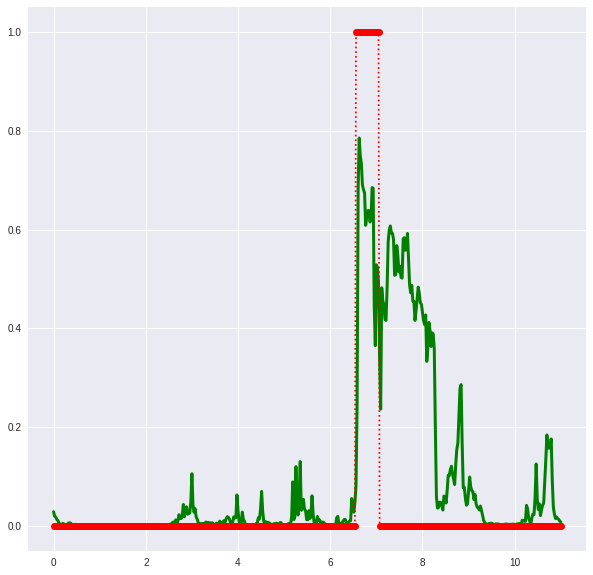

In [19]:
plot_sound_with_laught(131, result_test, test_y_seq[0].reshape(test_y_seq[0].shape[0], test_y_seq[0].shape[1]))

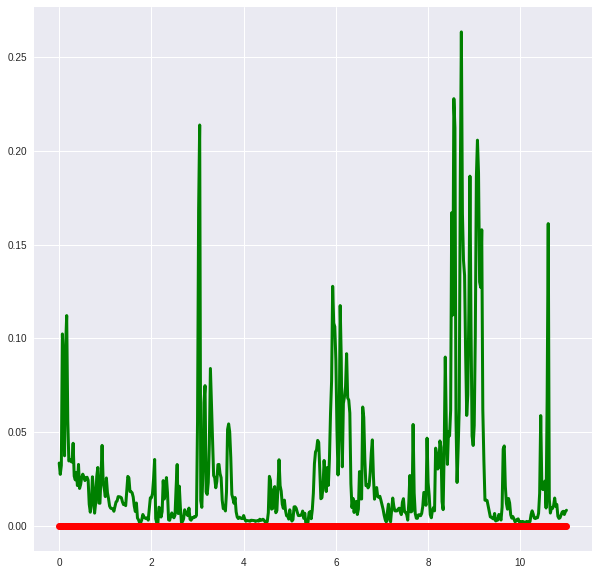

In [21]:
plot_sound_with_laught(431, result_test, test_y_seq[0].reshape(test_y_seq[0].shape[0], test_y_seq[0].shape[1]))

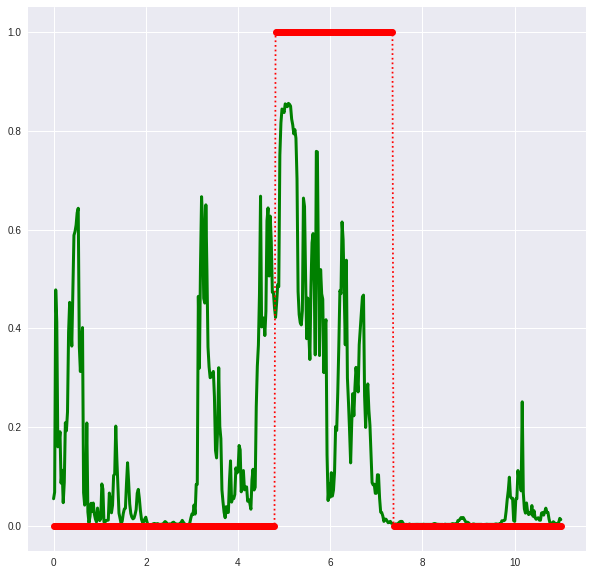

In [24]:
plot_sound_with_laught(483, result_test, test_y_seq[0].reshape(test_y_seq[0].shape[0], test_y_seq[0].shape[1]))

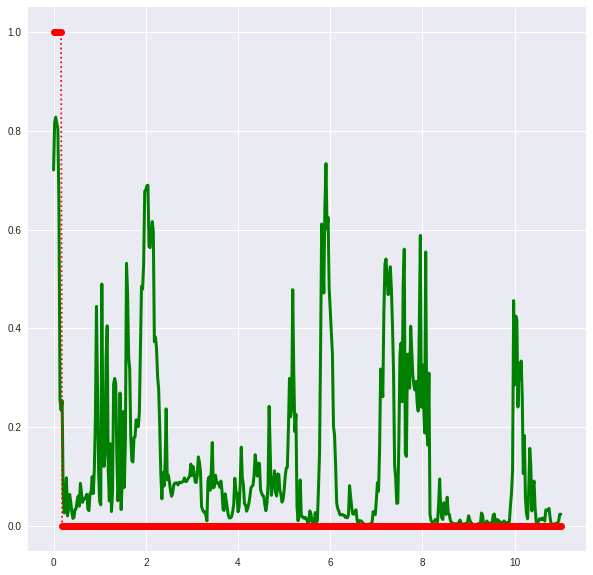

In [31]:
plot_sound_with_laught(79, result_test, test_y_seq[0].reshape(test_y_seq[0].shape[0], test_y_seq[0].shape[1]))

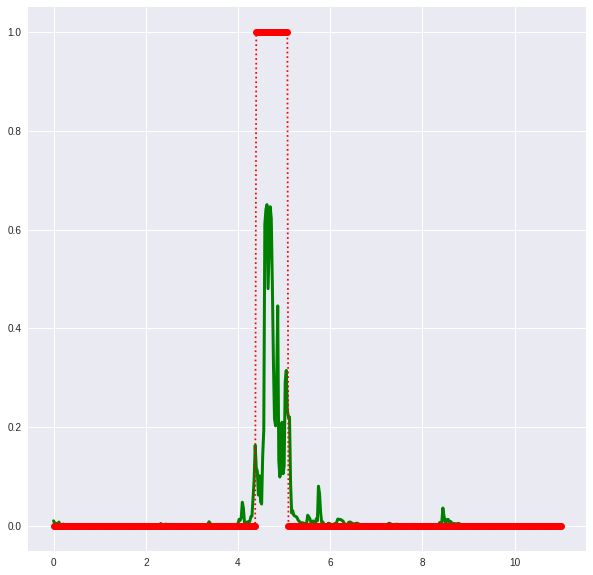

In [32]:
plot_sound_with_laught(179, result_test, test_y_seq[0].reshape(test_y_seq[0].shape[0], test_y_seq[0].shape[1]))

In [33]:
%%html
<marquee style='width: 30%; color: blue;'><b>Whee!</b></marquee>

**Now let's consider dataset with noise**

In [0]:
# del data, train_x, train_y, test_x, test_y
# del train_mfcc, train_fbank
# del train_mf_seq, train_fbank_seq, train_y_seq

# del test_mfcc, test_fbank
# del test_mf_seq, test_fbank_seq, test_y_seq

In [39]:
data_file_n = "gdrive/My Drive/Colab Notebooks/2_solution_colab" + \
              "/homework/vocalizationcorpus/" + \
              "data_csv/super_mega_file_474_expanded_noisy.csv"
data_n = pd.read_csv(data_file_n, sep=",", names=col_names)

data_n.head()

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,IS_LAUGHTER
0,-774.765868,51.965869,11.403024,38.322657,-15.187577,25.751888,7.056730,-10.047402,13.589122,-0.642071,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,0
1,-771.080759,52.170832,11.469751,39.211949,-17.354396,24.703801,9.862724,-7.481059,11.041431,-2.921237,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,0
2,-772.859716,48.599767,7.597807,37.360595,-17.867693,24.161158,7.589684,-11.482042,8.909090,-5.747069,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,0
3,-777.078815,46.571198,6.869962,37.503903,-15.772092,22.171728,3.001475,-14.345394,10.289235,-3.724221,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,0
4,-779.123295,45.040144,5.445280,37.390207,-16.665513,21.014096,6.779634,-11.556962,10.777100,-0.324580,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,0


In [41]:
train_x_n, train_y_n, test_x_n, test_y_n = get_data(data_n, segments_count)

print("train shape X = {}, train shape Y = {}".format(train_x_n[0].shape, train_y_n[0].shape))
print("test shape X = {}, test shape Y = {}".format(test_x_n[0].shape, test_y_n[0].shape))
print("number of train parts = {}".format(len(train_x_n)))
print("number of test parts = {}".format(len(test_x_n)))


# train data
train_samples_count_n = train_x_n[0].shape[0]
test_samples_count_n = test_x_n[0].shape[0]

train_mfcc_n, train_fbank_n = split_data_by_features(train_x_n, mfcc_features, 
                                                     mfcc_d_features, mfcc_dd_features, 
                                                     fbank_features)

print("train_mfcc shape = {}".format(train_mfcc_n[0].shape))
print("train_fbank shape = {}".format(train_fbank_n[0].shape))

train_mf_seq_n, train_fbank_seq_n = reshape_data_for_model(train_mfcc_n, 
                                                           train_fbank_n,
                                                           segments_count, 
                                                           mfcc_features + mfcc_d_features + mfcc_dd_features, 
                                                           fbank_features)

train_y_seq_n = reshape_labels_for_model(train_y_n, segments_count)
  
print("train_mfcc_seq shape = {}".format(train_mf_seq_n[0].shape))
print("train_fbank_seq shape = {}".format(train_fbank_seq_n[0].shape))
print()
print("train_Y_seq shape = {}".format(train_y_seq_n[0].shape))


# test data
test_mfcc_n, test_fbank_n = split_data_by_features(test_x_n, mfcc_features, 
                                                   mfcc_d_features, mfcc_dd_features, 
                                                   fbank_features)

print("test_mfcc shape = {}".format(test_mfcc_n[0].shape))
print("test_fbank shape = {}".format(test_fbank_n[0].shape))
print()

test_mf_seq_n, test_fbank_seq_n = reshape_data_for_model(test_mfcc_n, 
                                                         test_fbank_n,
                                                         segments_count, 
                                                         mfcc_features + mfcc_d_features + mfcc_dd_features, 
                                                         fbank_features)

test_y_seq_n = reshape_labels_for_model(test_y_n, segments_count)

print("test_mfcc_seq shape = {}".format(test_mf_seq_n[0].shape))
print("test_fbank_seq shape = {}".format(test_fbank_seq_n[0].shape))
print()
print("test_Y_seq shape = {}".format(test_y_seq_n[0].shape))


train shape X = (259278, 167), train shape Y = (259278,)
test shape X = (259278, 167), test shape Y = (259278,)
number of train parts = 4
number of test parts = 1
train_mfcc shape = (259278, 39)
train_fbank shape = (259278, 128)
train_mfcc_seq shape = (547, 474, 39)
train_fbank_seq shape = (547, 474, 128)

train_Y_seq shape = (547, 474, 1)
test_mfcc shape = (259278, 39)
test_fbank shape = (259278, 128)

test_mfcc_seq shape = (547, 474, 39)
test_fbank_seq shape = (547, 474, 128)

test_Y_seq shape = (547, 474, 1)


In [42]:
%%time

model.load_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model.h5")

model.fit([train_fbank_seq_n[0], train_mf_seq_n[0]], 
          [train_y_seq_n[0], train_y_seq_n[0]], 
          epochs=2, 
          steps_per_epoch=10)
model.save_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model_noise.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
10/10 [==============================] - 161s 16s/step - loss: 0.1608 - main_output_loss: 0.1319 - mfcc_output_loss: 0.1448 - main_output_acc: 0.9580 - mfcc_output_acc: 0.9570
Epoch 2/2
10/10 [==============================] - 152s 15s/step - loss: 0.1551 - main_output_loss: 0.1268 - mfcc_output_loss: 0.1415 - main_output_acc: 0.9590 - mfcc_output_acc: 0.9571
CPU times: user 7min 7s, sys: 2min 24s, total: 9min 32s
Wall time: 5min 17s


In [43]:
%%time

model.fit([train_fbank_seq_n[1], train_mf_seq_n[1]], 
          [train_y_seq_n[1], train_y_seq_n[1]], 
          epochs=2, 
          steps_per_epoch=10)
model.save_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model_noise.h5")

Epoch 1/2
10/10 [==============================] - 153s 15s/step - loss: 0.0952 - main_output_loss: 0.0777 - mfcc_output_loss: 0.0877 - main_output_acc: 0.9790 - mfcc_output_acc: 0.9785
Epoch 2/2
10/10 [==============================] - 149s 15s/step - loss: 0.0914 - main_output_loss: 0.0745 - mfcc_output_loss: 0.0843 - main_output_acc: 0.9792 - mfcc_output_acc: 0.9785
CPU times: user 7min 9s, sys: 2min 14s, total: 9min 24s
Wall time: 5min 3s


In [44]:
%%time

model.fit([train_fbank_seq_n[2], train_mf_seq_n[2]], 
          [train_y_seq_n[2], train_y_seq_n[2]], 
          epochs=2, 
          steps_per_epoch=10)
model.save_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model_noise.h5")

Epoch 1/2
10/10 [==============================] - 151s 15s/step - loss: 0.1255 - main_output_loss: 0.1024 - mfcc_output_loss: 0.1156 - main_output_acc: 0.9685 - mfcc_output_acc: 0.9669
Epoch 2/2
10/10 [==============================] - 150s 15s/step - loss: 0.1233 - main_output_loss: 0.1004 - mfcc_output_loss: 0.1143 - main_output_acc: 0.9688 - mfcc_output_acc: 0.9669
CPU times: user 7min 7s, sys: 2min 14s, total: 9min 22s
Wall time: 5min 2s


In [45]:
%%time

model.fit([train_fbank_seq_n[3], train_mf_seq_n[3]], 
          [train_y_seq_n[3], train_y_seq_n[3]], 
          epochs=2, 
          steps_per_epoch=10)
model.save_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model_noise.h5")

Epoch 1/2
10/10 [==============================] - 151s 15s/step - loss: 0.1100 - main_output_loss: 0.0904 - mfcc_output_loss: 0.0978 - main_output_acc: 0.9758 - mfcc_output_acc: 0.9749
Epoch 2/2
10/10 [==============================] - 151s 15s/step - loss: 0.1084 - main_output_loss: 0.0891 - mfcc_output_loss: 0.0964 - main_output_acc: 0.9759 - mfcc_output_acc: 0.9750
CPU times: user 7min 9s, sys: 2min 14s, total: 9min 23s
Wall time: 5min 2s


In [54]:
%%time
model.load_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model_noise.h5")

result_test_n = np.array(model.predict([test_fbank_seq_n[0], test_mf_seq_n[0]], 
                                       steps=1, 
                                       verbose=1))[0].reshape(test_y_seq_n[0].shape[0],
                                                              test_y_seq_n[0].shape[1])

print("\nAUC on test = {}\n".format(roc_auc_score(test_y_seq_n[0].reshape(test_y_seq_n[0].shape[0], test_y_seq_n[0].shape[1]), 
                                                  result_test_n)))

1/1 [==============================] - 4s 4s/step

AUC on test = 0.8928746124836534

CPU times: user 7.84 s, sys: 530 ms, total: 8.37 s
Wall time: 5.18 s


In [47]:
np.sum(np.round(result_test_n) * test_y_seq_n[0].reshape(test_y_seq_n[0].shape[0], test_y_seq_n[0].shape[1]))

1730.0

In [48]:
%%time

model.evaluate([test_fbank_seq_n[0], test_mf_seq_n[0]], 
               [test_y_seq_n[0], test_y_seq_n[0]], 
               batch_size=5)

547/547 [==============================] - 12s 22ms/step
CPU times: user 21 s, sys: 438 ms, total: 21.5 s
Wall time: 11.9 s


[0.18536567296730644,
 0.15225521598685485,
 0.165552281554945,
 0.9501770270589937,
 0.9452556665898241]

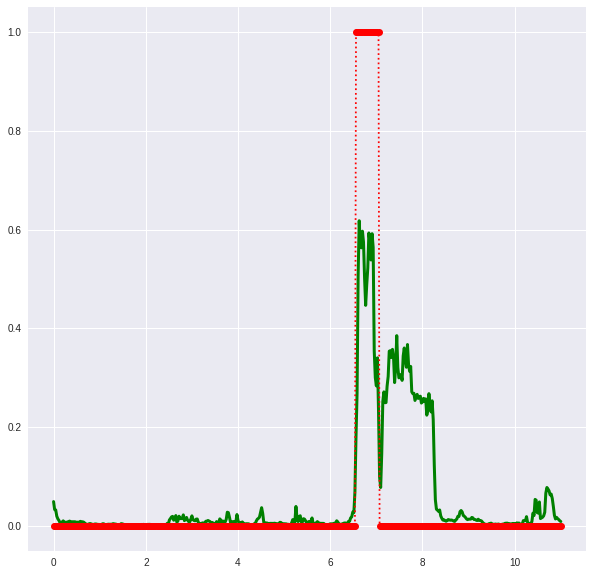

In [50]:
plot_sound_with_laught(131, result_test_n, test_y_seq_n[0].reshape(test_y_seq_n[0].shape[0], test_y_seq_n[0].shape[1]))

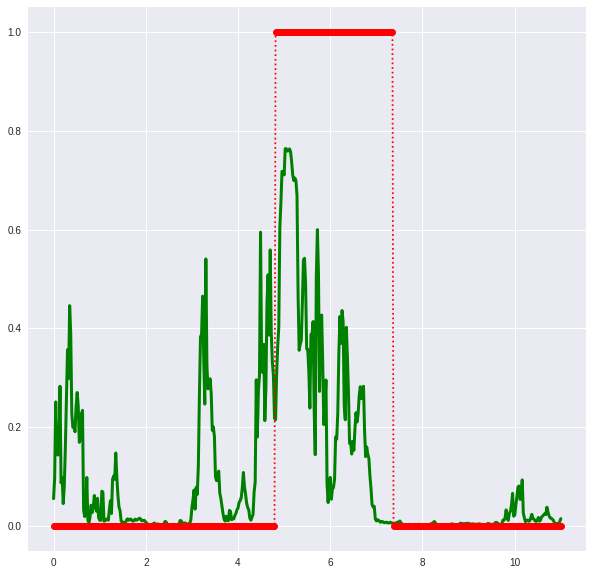

In [55]:
plot_sound_with_laught(483, result_test_n, test_y_seq_n[0].reshape(test_y_seq_n[0].shape[0], test_y_seq_n[0].shape[1]))

## Let's check the origin model for data with noise with no additional lerning 

In [51]:
model.load_weights("gdrive/My Drive/Colab Notebooks/2_solution_colab/weights_another_model.h5")

print("number of '1' match = {}".format(np.sum(np.round(result_test_n) * test_y_seq_n[0].reshape(test_y_seq_n[0].shape[0], 
                                                                                                 test_y_seq_n[0].shape[1]))))

result_test_n = np.array(model.predict([test_fbank_seq_n[0], test_mf_seq_n[0]], 
                                       steps=1, 
                                       verbose=1))[0].reshape(test_y_seq_n[0].shape[0],
                                                              test_y_seq_n[0].shape[1])

print("\nAUC on test = {}\n".format(roc_auc_score(test_y_seq_n[0].reshape(test_y_seq_n[0].shape[0], test_y_seq_n[0].shape[1]), 
                                                  result_test_n)))

number of '1' match = 1730.0
1/1 [==============================] - 5s 5s/step

AUC on test = 0.8938592458296307



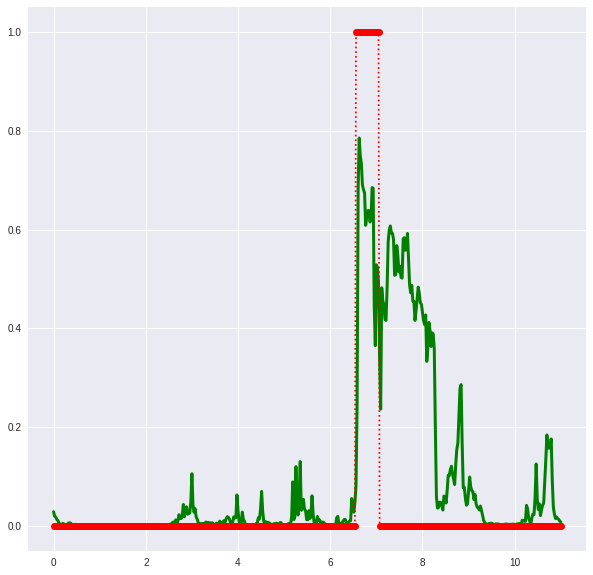

In [52]:
plot_sound_with_laught(131, result_test_n, test_y_seq_n[0].reshape(test_y_seq_n[0].shape[0], test_y_seq_n[0].shape[1]))

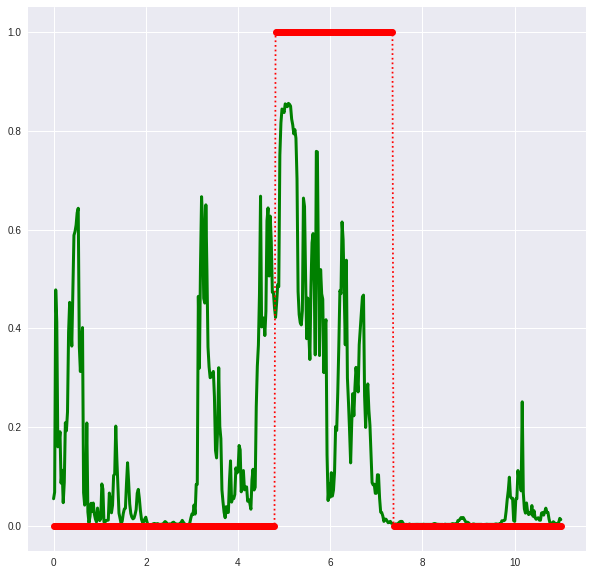

In [53]:
plot_sound_with_laught(483, result_test_n, test_y_seq_n[0].reshape(test_y_seq_n[0].shape[0], test_y_seq_n[0].shape[1]))

### *AUC was better with no additional learning but, as you can see on the plot, the uplearning model better allocates the desire segments.*